Sebastian Raschka, 2015-2020    
`mlxtend`, a library of extension and helper modules for Python's data analysis and machine learning libraries

- GitHub repository: https://github.com/rasbt/mlxtend
- Documentation: http://rasbt.github.io/mlxtend/

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p matplotlib,numpy,scipy,mlxtend

Sebastian Raschka 
last updated: 2021-02-07 

CPython 3.8.2
IPython 7.18.1

matplotlib 3.3.1
numpy 1.18.5
scipy 1.5.0
mlxtend 0.18.0


In [2]:
%matplotlib inline

# Sequential Feature Selector

Implementation of *sequential feature algorithms* (SFAs) -- greedy search algorithms -- that have been developed as a suboptimal solution to the computationally often not feasible exhaustive search.

> from mlxtend.feature_selection import SequentialFeatureSelector

## Overview

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial *d*-dimensional feature space to a *k*-dimensional feature subspace where *k < d*. The motivation behind feature selection algorithms is to automatically select a subset of features that is most relevant to the problem. The goal of feature selection is two-fold: We want to improve the computational efficiency and reduce the generalization error of the model by removing irrelevant features or noise. A wrapper approach such as sequential feature selection is especially useful if embedded feature selection -- for example, a regularization penalty like LASSO -- is not applicable.

In a nutshell, SFAs remove or add one feature at the time based on the classifier performance until a feature subset of the desired size *k* is reached. There are 4 different flavors of SFAs available via the `SequentialFeatureSelector`:

1. Sequential Forward Selection (SFS)
2. Sequential Backward Selection (SBS)
3. Sequential Forward Floating Selection (SFFS)
4. Sequential Backward Floating Selection (SBFS)

The ***floating*** variants, SFFS and SBFS, can be considered as extensions to the simpler SFS and SBS algorithms. The floating algorithms have an additional exclusion or inclusion step to remove features once they were included (or excluded), so that a larger number of feature subset combinations can be sampled. It is important to emphasize that this step is conditional and only occurs if the resulting feature subset is assessed as "better" by the criterion function after removal (or addition) of a particular feature. Furthermore, I added an optional check to skip the conditional exclusion steps if the algorithm gets stuck in cycles.  


---

How is this different from *Recursive Feature Elimination* (RFE)  -- e.g., as implemented in `sklearn.feature_selection.RFE`? RFE is computationally less complex using the feature weight coefficients (e.g., linear models) or feature importance (tree-based algorithms) to eliminate features recursively, whereas SFSs eliminate (or add) features based on a user-defined classifier/regression performance metric.

---

The SFAs  are outlined in pseudo code below:

### Sequential Forward Selection (SFS)


**Input:** $Y = \{y_1, y_2, ..., y_d\}$  

- The ***SFS*** algorithm takes the whole $d$-dimensional feature set as input.


**Output:** $X_k = \{x_j \; | \;j = 1, 2, ..., k; \; x_j \in Y\}$, where $k = (0, 1, 2, ..., d)$

- SFS returns a subset of features; the number of selected features $k$, where $k < d$, has to be specified *a priori*.

**Initialization:** $X_0 = \emptyset$, $k = 0$

- We initialize the algorithm with an empty set $\emptyset$ ("null set") so that $k = 0$ (where $k$ is the size of the subset).

**Step 1 (Inclusion):**  

  $x^+ = \text{ arg max } J(X_k + x), \text{ where }  x \in Y - X_k$  
  $X_{k+1} = X_k + x^+$  
  $k = k + 1$    
  *Go to Step 1* 

- in this step, we add an additional feature, $x^+$, to our feature subset $X_k$.
- $x^+$ is the feature that maximizes our criterion function, that is, the feature that is associated with the best classifier performance if it is added to $X_k$.
- We repeat this procedure until the termination criterion is satisfied.

**Termination:** $k = p$

- We add features from the feature subset $X_k$ until the feature subset of size $k$ contains the number of desired features $p$ that we specified *a priori*.

### Sequential Backward Selection (SBS)

**Input:** the set of all features, $Y = \{y_1, y_2, ..., y_d\}$  

- The SBS algorithm takes the whole feature set as input.

**Output:** $X_k = \{x_j \; | \;j = 1, 2, ..., k; \; x_j \in Y\}$, where $k = (0, 1, 2, ..., d)$

- SBS returns a subset of features; the number of selected features $k$, where $k < d$, has to be specified *a priori*.

**Initialization:** $X_0 = Y$, $k = d$

- We initialize the algorithm with the given feature set so that the $k = d$.


**Step 1 (Exclusion):**  

$x^- = \text{ arg max } J(X_k - x), \text{  where } x \in X_k$  
$X_{k-1} = X_k - x^-$  
$k = k - 1$  
*Go to Step 1*  

- In this step, we remove a feature, $x^-$ from our feature subset $X_k$.
- $x^-$ is the feature that maximizes our criterion function upon re,oval, that is, the feature that is associated with the best classifier performance if it is removed from $X_k$.
- We repeat this procedure until the termination criterion is satisfied.


**Termination:** $k = p$

- We add features from the feature subset $X_k$ until the feature subset of size $k$ contains the number of desired features $p$ that we specified *a priori*.



### Sequential Backward Floating Selection (SBFS)

**Input:** the set of all features, $Y = \{y_1, y_2, ..., y_d\}$  

- The SBFS algorithm takes the whole feature set as input.

**Output:** $X_k = \{x_j \; | \;j = 1, 2, ..., k; \; x_j \in Y\}$, where $k = (0, 1, 2, ..., d)$

- SBFS returns a subset of features; the number of selected features $k$, where $k < d$, has to be specified *a priori*.

**Initialization:** $X_0 = Y$, $k = d$

- We initialize the algorithm with the given feature set so that the $k = d$.

**Step 1 (Exclusion):**  

$x^- = \text{ arg max } J(X_k - x), \text{  where } x \in X_k$  
$X_{k-1} = X_k - x^-$  
$k = k - 1$  
*Go to Step 2*  

- In this step, we remove a feature, $x^-$ from our feature subset $X_k$.
- $x^-$ is the feature that maximizes our criterion function upon re,oval, that is, the feature that is associated with the best classifier performance if it is removed from $X_k$.


**Step 2 (Conditional Inclusion):**  
<br>
$x^+ = \text{ arg max } J(X_k + x), \text{ where } x \in Y - X_k$  
*if J(X_k + x) > J(X_k)*:    
&nbsp;&nbsp;&nbsp;&nbsp; $X_{k+1} = X_k + x^+$  
&nbsp;&nbsp;&nbsp;&nbsp; $k = k + 1$  
*Go to Step 1*  

- In Step 2, we search for features that improve the classifier performance if they are added back to the feature subset. If such features exist, we add the feature $x^+$ for which the performance improvement is maximized. If $k = 2$ or an improvement cannot be made (i.e., such feature $x^+$ cannot be found), go back to step 1; else, repeat this step.


**Termination:** $k = p$

- We add features from the feature subset $X_k$ until the feature subset of size $k$ contains the number of desired features $p$ that we specified *a priori*.


### Sequential Forward Floating Selection (SFFS)

**Input:** the set of all features, $Y = \{y_1, y_2, ..., y_d\}$  

- The ***SFFS*** algorithm takes the whole feature set as input, if our feature space consists of, e.g. 10, if our feature space consists of 10 dimensions (***d = 10***).
<br><br>

**Output:** a subset of features, $X_k = \{x_j \; | \;j = 1, 2, ..., k; \; x_j \in Y\}$, where $k = (0, 1, 2, ..., d)$

- The returned output of the algorithm is a subset of the feature space of a specified size. E.g., a subset of 5 features from a 10-dimensional feature space (***k = 5, d = 10***).
<br><br>

**Initialization:** $X_0 = \emptyset$, $k = 0$

- We initialize the algorithm with an empty set ("null set") so that the ***k = 0*** (where ***k*** is the size of the subset)
<br><br>

**Step 1 (Inclusion):**  
<br>
&nbsp;&nbsp;&nbsp;&nbsp; $x^+ = \text{ arg max } J(X_k + x), \text{ where }  x \in Y - X_k$  
&nbsp;&nbsp;&nbsp;&nbsp; $X_{k+1} = X_k + x^+$  
&nbsp;&nbsp;&nbsp;&nbsp; $k = k + 1$    
&nbsp;&nbsp;&nbsp;&nbsp;*Go to Step 2*  
<br> <br>
**Step 2 (Conditional Exclusion):**  
<br>
&nbsp;&nbsp;&nbsp;&nbsp; $x^- = \text{ arg max } J(X_k - x), \text{ where } x \in X_k$  
&nbsp;&nbsp;&nbsp;&nbsp;$if \; J(X_k - x) > J(X_k)$:    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $X_{k-1} = X_k - x^- $  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k = k - 1$    
&nbsp;&nbsp;&nbsp;&nbsp;*Go to Step 1*  

- In step 1, we include the feature from the ***feature space*** that leads to the best performance increase for our ***feature subset*** (assessed by the ***criterion function***). Then, we go over to step 2
- In step 2, we only remove a feature if the resulting subset would gain an increase in performance. If $k = 2$ or an improvement cannot be made (i.e., such feature $x^+$ cannot be found), go back to step 1; else, repeat this step.


- Steps 1 and 2 are repeated until the **Termination** criterion is reached.
<br><br>

**Termination:** stop when ***k*** equals the number of desired features


A visual illustration of the sequential backward selection process is provided below, from the paper

- Joe Bemister-Buffington, Alex J. Wolf, Sebastian Raschka, and Leslie A. Kuhn (2020)
Machine Learning to Identify Flexibility Signatures of Class A GPCR Inhibition
Biomolecules 2020, 10, 454. https://www.mdpi.com/2218-273X/10/3/454#

![](SequentialFeatureSelector_files/sbs-gpcr2020.png)

### References

- Ferri, F. J., Pudil P., Hatef, M., Kittler, J. (1994). [*"Comparative study of techniques for large-scale feature selection."*](https://books.google.com/books?hl=en&lr=&id=sbajBQAAQBAJ&oi=fnd&pg=PA403&dq=comparative+study+of+techniques+for+large+scale&ots=KdIOYpA8wj&sig=hdOsBP1HX4hcDjx4RLg_chheojc#v=onepage&q=comparative%20study%20of%20techniques%20for%20large%20scale&f=false) Pattern Recognition in Practice IV : 403-413.

- Pudil, P., Novovičová, J., & Kittler, J. (1994). [*"Floating search methods in feature selection."*](http://www.sciencedirect.com/science/article/pii/0167865594901279) Pattern recognition letters 15.11 (1994): 1119-1125.

## Example 1 - A simple Sequential Forward Selection example

Initializing a simple classifier from scikit-learn:

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
knn = KNeighborsClassifier(n_neighbors=4)

We start by selection the "best" 3 features from the Iris dataset via Sequential Forward Selection (SFS). Here, we set `forward=True` and `floating=False`. By choosing `cv=0`, we don't perform any cross-validation, therefore, the performance (here: `'accuracy'`) is computed entirely on the training set. 

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2021-02-07 20:14:48] Features: 1/3 -- score: 0.96[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2021-02-07 20:14:48] Features: 2/3 -- score: 0.9733333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-02-07 20:14:48] Features: 3/3 -- score: 0.9733333333333334

Via the `subsets_` attribute, we can take a look at the selected feature indices at each step:

In [5]:
sfs1.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.96]),
  'avg_score': 0.96,
  'feature_names': ('3',)},
 2: {'feature_idx': (2, 3),
  'cv_scores': array([0.97333333]),
  'avg_score': 0.9733333333333334,
  'feature_names': ('2', '3')},
 3: {'feature_idx': (1, 2, 3),
  'cv_scores': array([0.97333333]),
  'avg_score': 0.9733333333333334,
  'feature_names': ('1', '2', '3')}}

Note that the 'feature_names' entry is simply a string representation of the 'feature_idx' in this case. Optionally, we can provide custom feature names via the `fit` method's `custom_feature_names` parameter:

In [6]:
feature_names = ('sepal length', 'sepal width', 'petal length', 'petal width')
sfs1 = sfs1.fit(X, y, custom_feature_names=feature_names)
sfs1.subsets_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2021-02-07 20:14:48] Features: 1/3 -- score: 0.96[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2021-02-07 20:14:48] Features: 2/3 -- score: 0.9733333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-02-07 20:14:48] Features: 3/3 -- score: 0.9733333333333334

{1: {'feature_idx': (3,),
  'cv_scores': array([0.96]),
  'avg_score': 0.96,
  'feature_names': ('petal width',)},
 2: {'feature_idx': (2, 3),
  'cv_scores': array([0.97333333]),
  'avg_score': 0.9733333333333334,
  'feature_names': ('petal length', 'petal width')},
 3: {'feature_idx': (1, 2, 3),
  'cv_scores': array([0.97333333]),
  'avg_score': 0.9733333333333334,
  'feature_names': ('sepal width', 'petal length', 'petal width')}}

Furthermore, we can access the indices of the 3 best features directly via the `k_feature_idx_` attribute:

In [7]:
sfs1.k_feature_idx_

(1, 2, 3)

And similarly, to obtain the names of these features, given that we provided an argument to the `custom_feature_names` parameter, we can refer to the `sfs1.k_feature_names_` attribute:

In [8]:
sfs1.k_feature_names_

('sepal width', 'petal length', 'petal width')

Finally, the prediction score for these 3 features can be accesses via `k_score_`:

In [9]:
sfs1.k_score_

0.9733333333333334

## Example 2 - Toggling between SFS, SBS, SFFS, and SBFS

Using the `forward` and `floating` parameters, we can toggle between SFS, SBS, SFFS, and SBFS as shown below. Note that we are performing (stratified) 4-fold cross-validation for more robust estimates in contrast to Example 1. Via `n_jobs=-1`, we choose to run the cross-validation on all our available CPU cores.

In [10]:
# Sequential Forward Selection
sfs = SFS(knn, 
          k_features=3, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sfs = sfs.fit(X, y)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)

###################################################

# Sequential Backward Selection
sbs = SFS(knn, 
          k_features=3, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sbs = sbs.fit(X, y)

print('\nSequential Backward Selection (k=3):')
print(sbs.k_feature_idx_)
print('CV Score:')
print(sbs.k_score_)

###################################################

# Sequential Forward Floating Selection
sffs = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sffs = sffs.fit(X, y)

print('\nSequential Forward Floating Selection (k=3):')
print(sffs.k_feature_idx_)
print('CV Score:')
print(sffs.k_score_)

###################################################

# Sequential Backward Floating Selection
sbfs = SFS(knn, 
           k_features=3, 
           forward=False, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sbfs = sbfs.fit(X, y)

print('\nSequential Backward Floating Selection (k=3):')
print(sbfs.k_feature_idx_)
print('CV Score:')
print(sbfs.k_score_)


Sequential Forward Selection (k=3):
(1, 2, 3)
CV Score:
0.9731507823613088

Sequential Backward Selection (k=3):
(1, 2, 3)
CV Score:
0.9731507823613088

Sequential Forward Floating Selection (k=3):
(1, 2, 3)
CV Score:
0.9731507823613088

Sequential Backward Floating Selection (k=3):
(1, 2, 3)
CV Score:
0.9731507823613088


In this simple scenario, selecting the best 3 features out of the 4 available features in the Iris set, we end up with similar results regardless of which sequential selection algorithms we used.

## Example 3 - Visualizing the results in DataFrames

 For our convenience, we can visualize the output from the feature selection in a pandas DataFrame format using the `get_metric_dict` method of the SequentialFeatureSelector object. The columns `std_dev` and `std_err` represent the standard deviation and standard errors of the cross-validation scores, respectively.

Below, we see the DataFrame of the Sequential Forward Selector from Example 2:

In [11]:
import pandas as pd
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.9736842105263158, 0.9473684210526315, 0.891...",0.953236,"(3,)",0.0641319,0.0400079,0.0230986
2,"(2, 3)","[0.9736842105263158, 0.9473684210526315, 0.918...",0.959993,"(2, 3)",0.0483191,0.0301433,0.0174032
3,"(1, 2, 3)","[0.9736842105263158, 1.0, 0.9459459459459459, ...",0.973151,"(1, 2, 3)",0.0306385,0.0191135,0.0110352


Now, let's compare it to the Sequential Backward Selector:

In [12]:
pd.DataFrame.from_dict(sbs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(0, 1, 2, 3)","[0.9736842105263158, 0.9473684210526315, 0.918...",0.953236,"(0, 1, 2, 3)",0.0360205,0.0224709,0.0129736
3,"(1, 2, 3)","[0.9736842105263158, 1.0, 0.9459459459459459, ...",0.973151,"(1, 2, 3)",0.0306385,0.0191135,0.0110352


We can see that both SFS and SBFS found the same "best" 3 features, however, the intermediate steps where obviously different.

The `ci_bound` column in the DataFrames above represents the confidence interval around the computed cross-validation scores. By default, a confidence interval of 95% is used, but we can use different confidence bounds via the `confidence_interval` parameter. E.g., the confidence bounds for a 90% confidence interval can be obtained as follows:

In [13]:
pd.DataFrame.from_dict(sbs.get_metric_dict(confidence_interval=0.90)).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(0, 1, 2, 3)","[0.9736842105263158, 0.9473684210526315, 0.918...",0.953236,"(0, 1, 2, 3)",0.0276577,0.0224709,0.0129736
3,"(1, 2, 3)","[0.9736842105263158, 1.0, 0.9459459459459459, ...",0.973151,"(1, 2, 3)",0.0235253,0.0191135,0.0110352


## Example 4 - Plotting the results

After importing the little helper function [`plotting.plot_sequential_feature_selection`](../plotting/plot_sequential_feature_selection.md), we can also visualize the results using matplotlib figures.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2021-02-07 20:14:51] Features: 1/4 -- score: 0.96[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2021-02-07 20:14:51] Features: 2/4 -- score: 0.9666666666666668[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-02-07 20:14:52] Features: 3/4 -- score: 0.9533333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | e

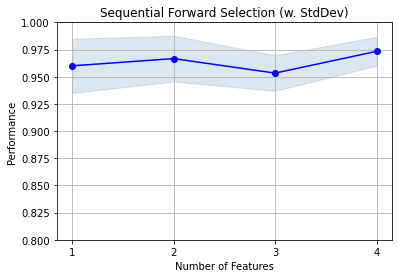

In [14]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

sfs = SFS(knn, 
          k_features=4, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          verbose=2,
          cv=5)

sfs = sfs.fit(X, y)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Example 5 - Sequential Feature Selection for Regression

Similar to the classification examples above, the `SequentialFeatureSelector` also supports scikit-learn's estimators
for regression.

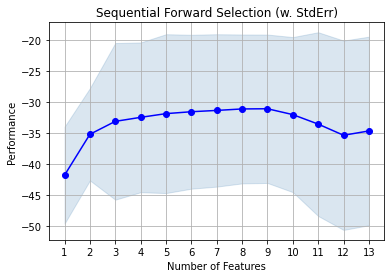

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

boston = load_boston()
X, y = boston.data, boston.target

lr = LinearRegression()

sfs = SFS(lr, 
          k_features=13, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

## Example 6 -- Feature Selection with Fixed Train/Validation Splits

If you do not wish to use cross-validation (here: k-fold cross-validation, i.e., rotating training and validation folds), you can use the `PredefinedHoldoutSplit` class to specify your own, fixed training and validation split.

In [16]:
from sklearn.datasets import load_iris
from mlxtend.evaluate import PredefinedHoldoutSplit
import numpy as np


iris = load_iris()
X = iris.data
y = iris.target

rng = np.random.RandomState(123)
my_validation_indices = rng.permutation(np.arange(150))[:30]
print(my_validation_indices)

[ 72 112 132  88  37 138  87  42   8  90 141  33  59 116 135 104  36  13
  63  45  28 133  24 127  46  20  31 121 117   4]


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS



knn = KNeighborsClassifier(n_neighbors=4)
piter = PredefinedHoldoutSplit(my_validation_indices)

sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=piter)

sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2021-02-07 20:14:53] Features: 1/3 -- score: 0.9666666666666667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2021-02-07 20:14:53] Features: 2/3 -- score: 0.9666666666666667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-02-07 20:14:53] Features: 3/3 -- score: 0.9666666666666667

## Example 7 -- Using the Selected Feature Subset For Making New Predictions

In [18]:
# Initialize the dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.33, random_state=1)

knn = KNeighborsClassifier(n_neighbors=4)

In [19]:
# Select the "best" three features via
# 5-fold cross-validation on the training set.

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=5)
sfs1 = sfs1.fit(X_train, y_train)

In [20]:
print('Selected features:', sfs1.k_feature_idx_)

Selected features: (1, 2, 3)


In [21]:
# Generate the new subsets based on the selected features
# Note that the transform call is equivalent to
# X_train[:, sfs1.k_feature_idx_]

X_train_sfs = sfs1.transform(X_train)
X_test_sfs = sfs1.transform(X_test)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
knn.fit(X_train_sfs, y_train)
y_pred = knn.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

Test set accuracy: 96.00 %


## Example 8 -- Sequential Feature Selection and GridSearch

In [22]:
# Initialize the dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.2, random_state=123)

Use scikit-learn's `GridSearch` to tune the hyperparameters inside and outside the `SequentialFeatureSelector`:

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import mlxtend

knn = KNeighborsClassifier(n_neighbors=2)

sfs1 = SFS(estimator=knn, 
           k_features=3,
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=5)

pipe = Pipeline([('sfs', sfs1), 
                 ('knn', knn)])

param_grid = [
  {'sfs__k_features': [1, 4],
   'sfs__estimator__n_neighbors': [1, 5, 10]}
  ]
    
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=5,
                  refit=False)

# run gridearch
gs = gs.fit(X_train, y_train)

... and the "best" parameters determined by GridSearch are ...

In [24]:
for i in range(len(gs.cv_results_['params'])):
    print(gs.cv_results_['params'][i], 'test acc.:', gs.cv_results_['mean_test_score'][i])

{'sfs__estimator__n_neighbors': 1, 'sfs__k_features': 1} test acc.: 0.9166666666666667
{'sfs__estimator__n_neighbors': 1, 'sfs__k_features': 4} test acc.: 0.9416666666666668
{'sfs__estimator__n_neighbors': 5, 'sfs__k_features': 1} test acc.: 0.9166666666666667
{'sfs__estimator__n_neighbors': 5, 'sfs__k_features': 4} test acc.: 0.9416666666666668
{'sfs__estimator__n_neighbors': 10, 'sfs__k_features': 1} test acc.: 0.9166666666666667
{'sfs__estimator__n_neighbors': 10, 'sfs__k_features': 4} test acc.: 0.9416666666666668


In [25]:
print("Best parameters via GridSearch", gs.best_params_)

Best parameters via GridSearch {'sfs__estimator__n_neighbors': 1, 'sfs__k_features': 4}


#### Obtaining the best *k* feature indices after GridSearch

If we are interested in the best *k* feature indices via `SequentialFeatureSelection.k_feature_idx_`, we have to initialize a `GridSearchCV` object with `refit=True`. Now, the grid search object will take the complete training dataset and the best parameters, which it found via cross-validation, to train the estimator pipeline.

In [26]:
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=5, 
                  refit=True)
gs = gs.fit(X_train, y_train)

After running the grid search, we can access the individual pipeline objects of the `best_estimator_` via the `steps` attribute.

In [27]:
gs.best_estimator_.steps

[('sfs',
  SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=1),
                            k_features=4, scoring='accuracy')),
 ('knn', KNeighborsClassifier(n_neighbors=2))]

Via sub-indexing, we can then obtain the best-selected feature subset:

In [28]:
print('Best features:', gs.best_estimator_.steps[0][1].k_feature_idx_)

Best features: (0, 1, 2, 3)


During cross-validation, this feature combination had a CV accuracy of:

In [29]:
print('Best score:', gs.best_score_)

Best score: 0.9416666666666668


In [30]:
gs.best_params_

{'sfs__estimator__n_neighbors': 1, 'sfs__k_features': 4}

Just to ensure that the values were indeed assigned correctly, the following number of neighbors should match the one above:

In [31]:
gs.estimator.named_steps['sfs'].estimator.n_neighbors

2

**Alternatively**, if we can set the "best grid search parameters" in our pipeline manually if we ran `GridSearchCV` with `refit=False`. It should yield the same results:

In [32]:
pipe.set_params(**gs.best_params_).fit(X_train, y_train)
print('Best features:', pipe.steps[0][1].k_feature_idx_)

Best features: (0, 1, 2, 3)


## Example 9 -- Selecting the "best"  feature combination in a k-range

If `k_features` is set to to a tuple `(min_k, max_k)` (new in 0.4.2), the SFS will now select the best feature combination that it discovered by iterating from `k=1` to `max_k` (forward), or `max_k` to `min_k` (backward). The size of the returned feature subset is then within `max_k` to `min_k`, depending on which combination scored best during cross validation.



In [33]:
X.shape

(150, 4)

best combination (ACC: 0.992): (0, 1, 2, 3, 6, 8, 9, 10, 11, 12)

all subsets:
 {1: {'feature_idx': (6,), 'cv_scores': array([0.84 , 0.64 , 0.84 , 0.76 , 0.875]), 'avg_score': 0.791, 'feature_names': ('6',)}, 2: {'feature_idx': (6, 9), 'cv_scores': array([0.92      , 0.88      , 1.        , 0.96      , 0.91666667]), 'avg_score': 0.9353333333333333, 'feature_names': ('6', '9')}, 3: {'feature_idx': (6, 9, 12), 'cv_scores': array([0.92      , 0.92      , 0.96      , 1.        , 0.95833333]), 'avg_score': 0.9516666666666665, 'feature_names': ('6', '9', '12')}, 4: {'feature_idx': (3, 6, 9, 12), 'cv_scores': array([0.96      , 0.96      , 0.96      , 1.        , 0.95833333]), 'avg_score': 0.9676666666666666, 'feature_names': ('3', '6', '9', '12')}, 5: {'feature_idx': (3, 6, 9, 10, 12), 'cv_scores': array([0.92, 0.96, 1.  , 1.  , 1.  ]), 'avg_score': 0.976, 'feature_names': ('3', '6', '9', '10', '12')}, 6: {'feature_idx': (2, 3, 6, 9, 10, 12), 'cv_scores': array([0.92, 0.96, 1.  , 0.96, 1.  ]

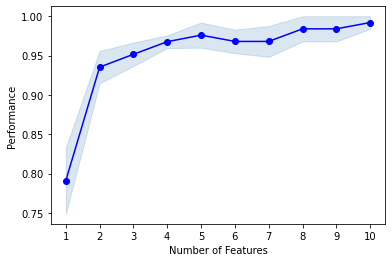

In [34]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import wine_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X, y = wine_data()
X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                   stratify=y,
                                                   test_size=0.3,
                                                   random_state=1)

knn = KNeighborsClassifier(n_neighbors=2)

sfs1 = SFS(estimator=knn, 
           k_features=(3, 10),
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=5)

pipe = make_pipeline(StandardScaler(), sfs1)

pipe.fit(X_train, y_train)

print('best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
print('all subsets:\n', sfs1.subsets_)
plot_sfs(sfs1.get_metric_dict(), kind='std_err');

## Example 10 -- Using other cross-validation schemes

In addition to standard k-fold and stratified k-fold, other cross validation schemes can be used with `SequentialFeatureSelector`. For example, `GroupKFold` or `LeaveOneOut` cross-validation from scikit-learn. 

#### Using GroupKFold with SequentialFeatureSelector

In [35]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import GroupKFold
import numpy as np

X, y = iris_data()
groups = np.arange(len(y)) // 10
print('groups: {}'.format(groups))

groups: [ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14]


Calling the `split()` method of a scikit-learn cross-validator object will return a generator that yields train, test splits.

In [36]:
cv_gen = GroupKFold(4).split(X, y, groups)
cv_gen

<generator object _BaseKFold.split at 0x7fdf79082ac0>

The `cv` parameter of `SequentialFeatureSelector` must be either an `int` or an iterable yielding train, test splits. This iterable can be constructed by passing the train, test split generator to the built-in `list()` function. 

In [37]:
cv = list(cv_gen)

In [38]:
knn = KNeighborsClassifier(n_neighbors=2)
sfs = SFS(estimator=knn, 
          k_features=2,
          scoring='accuracy',
          cv=cv)

sfs.fit(X, y)

print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))

best combination (ACC: 0.940): (2, 3)



## Example 11 - Working with pandas DataFrames

## Example 12 - Using Pandas DataFrames

Optionally, we can also use pandas DataFrames and pandas Series as input to the `fit` function. In this case, the column names of the pandas DataFrame will be used as feature names. However, note that if `custom_feature_names` are provided in the fit function, these `custom_feature_names` take precedence over the DataFrame column-based feature names.

In [39]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


iris = load_iris()
X = iris.data
y = iris.target
knn = KNeighborsClassifier(n_neighbors=4)

sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=0)

In [40]:
X_df = pd.DataFrame(X, columns=['sepal len', 'petal len',
                                'sepal width', 'petal width'])
X_df.head()

,sepal len,petal len,sepal width,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Also, the target array, `y`, can be optionally be cast as a Series:

In [41]:
y_series = pd.Series(y)
y_series.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [42]:
sfs1 = sfs1.fit(X_df, y_series)

Note that the only difference of passing a pandas DataFrame as input is that the sfs1.subsets_ array will now contain a new column, 

In [43]:
sfs1.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.96]),
  'avg_score': 0.96,
  'feature_names': ('petal width',)},
 2: {'feature_idx': (2, 3),
  'cv_scores': array([0.97333333]),
  'avg_score': 0.9733333333333334,
  'feature_names': ('sepal width', 'petal width')},
 3: {'feature_idx': (1, 2, 3),
  'cv_scores': array([0.97333333]),
  'avg_score': 0.9733333333333334,
  'feature_names': ('petal len', 'sepal width', 'petal width')}}

In mlxtend version >= 0.13 pandas DataFrames are supported as feature inputs to the `SequentianFeatureSelector` instead of NumPy arrays or other NumPy-like array types.

## Example 13 - Specifying Fixed Feature Sets

Often, it may be useful to specify a fixed set of features we want to use for a given model (e.g., determined by prior knowledge or domain knowledge). Since MLxtend v 0.18.0, it is now possible to specify such features via the `fixed_featurs` attribute. This will mean that these features are guaranteed to be included in the selected subsets.

Note that this feature works for all options regarding forward and backward selection, and using floating selection or not.

The example below illustrates how we can set the features 0 and 2 in the dataset as fixed:

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
knn = KNeighborsClassifier(n_neighbors=3)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(knn, 
           k_features=4, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           fixed_features=(0, 2),
           cv=3)

sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-02-07 20:14:58] Features: 3/4 -- score: 0.9733333333333333[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-02-07 20:14:58] Features: 4/4 -- score: 0.9733333333333333

In [45]:
sfs1.subsets_

{2: {'feature_idx': (0, 2),
  'cv_scores': array([0.96, 0.92, 0.94]),
  'avg_score': 0.94,
  'feature_names': ('0', '2')},
 3: {'feature_idx': (0, 2, 3),
  'cv_scores': array([0.98, 0.96, 0.98]),
  'avg_score': 0.9733333333333333,
  'feature_names': ('0', '2', '3')},
 4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([0.98, 0.96, 0.98]),
  'avg_score': 0.9733333333333333,
  'feature_names': ('0', '1', '2', '3')}}

If the input dataset is a pandas DataFrame, we can also use the column names directly:

In [46]:
import pandas as pd

In [47]:
X_df = pd.DataFrame(X, columns=['sepal len', 'petal len',
                                'sepal width', 'petal width'])
X_df.head()

,sepal len,petal len,sepal width,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [48]:
sfs2 = SFS(knn, 
           k_features=4, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           fixed_features=('sepal len', 'petal len'),
           cv=3)

sfs2 = sfs2.fit(X_df, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-02-07 20:14:58] Features: 3/4 -- score: 0.9466666666666667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-02-07 20:14:58] Features: 4/4 -- score: 0.9733333333333333

In [49]:
sfs2.subsets_

{2: {'feature_idx': (0, 1),
  'cv_scores': array([0.74, 0.72, 0.78]),
  'avg_score': 0.7466666666666667,
  'feature_names': ('sepal len', 'petal len')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([0.98, 0.92, 0.94]),
  'avg_score': 0.9466666666666667,
  'feature_names': ('sepal len', 'petal len', 'sepal width')},
 4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([0.98, 0.96, 0.98]),
  'avg_score': 0.9733333333333333,
  'feature_names': ('sepal len', 'petal len', 'sepal width', 'petal width')}}

# API

In [50]:
with open('../../api_modules/mlxtend.feature_selection/SequentialFeatureSelector.md', 'r') as f:
    s = f.read()
print(s)

## SequentialFeatureSelector

*SequentialFeatureSelector(estimator, k_features=1, forward=True, floating=False, verbose=0, scoring=None, cv=5, n_jobs=1, pre_dispatch='2*n_jobs', clone_estimator=True, fixed_features=None)*

Sequential Feature Selection for Classification and Regression.

**Parameters**

- `estimator` : scikit-learn classifier or regressor


- `k_features` : int or tuple or str (default: 1)

    Number of features to select,
    where k_features < the full feature set.
    New in 0.4.2: A tuple containing a min and max value can be provided,
    and the SFS will consider return any feature combination between
    min and max that scored highest in cross-validation. For example,
    the tuple (1, 4) will return any combination from
    1 up to 4 features instead of a fixed number of features k.
    New in 0.8.0: A string argument "best" or "parsimonious".
    If "best" is provided, the feature selector will return the
    feature subset with the best cross-validation perf